# Importando Feature Importance

In [1]:
import matplotlib.pyplot as plt
from sklearn.base import clone
import pandas as pd
import numpy as np

def get_columns_importance(model, x_train, y_train, x_to_verify, y_to_verify, metric_to_evaluate, mode, column_names, figsize=(12, 8)):
  """
    mode: {"greater", "lower"}
        Especifica el modo a usar para realizar para el cálculo de los "importances"
        - "greater": Se usa cuando la métrica que evaluamos es mejor mientras mayor sea su valor; por ejemplo, mientras mayor "accuracy" se tenga es mejor
        - "lower": Se usa cuando la métrica que evaluamos es mejor mientras menor sea su valor; por ejemplo, mientras menor "mean_squared_error" se tenga es mejor
  """

  assert mode in ["greater", "lower"], "The parameter 'mode' should be 'greater' or 'lower'"

  assert isinstance(x_train, (np.ndarray)), "The parameter 'x_train' should be a numpy array"
  assert isinstance(x_to_verify, (np.ndarray)), "The parameter 'x_to_verify' should be a numpy array"

  x_train = pd.DataFrame(x_train, columns=column_names)
  x_to_verify = pd.DataFrame(x_to_verify, columns=column_names)
  
  original_model = clone(model)

  if hasattr(original_model, "random_state"):
    original_model_random_state = original_model.random_state
  else:
    original_model_random_state = None
  
  original_model.fit(x_train, y_train)
  baseline_score = metric_to_evaluate(y_to_verify, original_model.predict(x_to_verify))

  importances = list()

  for column_name in column_names:
      x_train_without_column = x_train.drop(column_name, axis=1)
      x_to_verify_without_column = x_to_verify.drop(column_name, axis=1)

      new_model = clone(original_model)

      if original_model_random_state != None:
        new_model.random_state = original_model_random_state

      new_model.fit(x_train_without_column, y_train)
      new_score = metric_to_evaluate(y_to_verify, new_model.predict(x_to_verify_without_column))
      
      if mode == "greater":
        importance = new_score - baseline_score
      elif mode == "lower":
        importance = baseline_score - new_score
      else:
        raise Exception("The value provided for 'mode' is not supported")

      importances.append(importance)
  
  importances = np.array(importances)
  
  importances_report = pd.DataFrame(data={"column_names": column_names, "importances": importances})
  importances_report = importances_report.sort_values("importances", ascending=True)

  if mode == "greater":
    title = "Al eliminar las columnas con barras hacia la derecha, el valor de la métrica a evaluar aumenta\n"
    title += "Al eliminar las columnas con barras hacia la izquierda, el valor de la métrica a evaluar disminuye"
  elif mode == "lower":
    title = "Al eliminar las columnas con barras hacia la derecha, el valor de la métrica a evaluar disminuye\n"
    title += "Al eliminar las columnas con barras hacia la izquierda, el valor de la métrica a evaluar aumenta"
  else:
    raise Exception("The value provided for 'mode' is not supported")

  fig = plt.figure(figsize=figsize)
  plt.barh(importances_report.column_names, importances_report.importances.values, height=0.75)
  plt.axvline(x=0, color="r")
  plt.title(title)
  fig.tight_layout()
  plt.show()

  return importances_report

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('urbania_data_clean.csv')

# Dropeando Columnas que no aportan al modelo

In [4]:
df = df.drop(columns =["Descripcion", "Anunciante", "Fecha_pub", "latitud", "longitud", "Direccion"], axis = 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7644 entries, 0 to 7643
Columns: 205 entries, Antiguedad to Provincia_Provincia
dtypes: float64(11), int64(123), object(71)
memory usage: 12.0+ MB


# Convirtiendo las variables categoricas a numericas

In [6]:
# Luego de revisar cada columna..

## NUMERICAS
num_cols_originales = [
    'Antiguedad',
    'NroBanios',
    'Nro_pisos',
    'Cocheras',
    'Dormitorios',
    #'fecha_publicacion',
    'Precio',
    'Area_constr_m2',
    'Area_total_m2',

]

num_cols = [
    'Antiguedad',
    'NroBanios',
    'Nro_pisos',
    'Cocheras',
    'Dormitorios',
    #'fecha_publicacion',
    'Precio',
    'Area_constr_m2',
    'Area_total_m2',
    "ratioConstruccion",
    "ratioBanios",
    "ratioDormitorios",
    "diferenciaAreas"
]

col_garma = [
    'Cocheras',
    'Precio',
    'Area_constr_m2',
    'Area_total_m2',
    "ratioBanios",
    'NroBanios',
]

In [7]:
df = df.sort_values(by = 'fecha_publicacion')

In [8]:
df.select_dtypes('object').columns

Index(['Balneario', 'Uso_comercial', 'Uso_profesional', ''Cuarto de servicio'',
       ''Deposito'', ''Terraza'', ''Kitchenette'', ''Sala de estar'',
       ''Sotano'', ''Patio'', ''anx81tico'', ''Comedor diario'', ''Comedor'',
       ''Banio de servicio'', ''Jardanxadn Interno'', ''Walking Closet'',
       ''Escritorio'', ''Cocina'', ''Banio independiente'', ''Lavanderanxada'',
       ''Balcon'', ''Sala'', ''Closet'', ''Banio de visitas'', ''Agua'',
       ''Guardiananxada'', ''Internet'', ''Luz'', ''Cable'',
       ''Servicio de Limpieza'', ''Conexion a gas'', ''Sistema de seguridad'',
       ''Telefono'', ''Areadeportiva'', ''Piscina'', ''Solarium'',
       ''Sala de internet'', ''Sala de cine'', ''Jardanxadn'',
       ''Parque interno'', ''Guarderanxada'', ''anx81reas verdes'',
       ''Club House'', ''Hall de ingreso'', ''Areade BBQ'', ''Gimnasio'',
       ''Areade sauna'', ''Juegos para ninios'', ''Ingreso independiente'',
       ''Colegios cercanos'', ''Cerca al mar'',
       ''

## DF con solo variables numericas originales

In [9]:
df_num_org = df[num_cols_originales]

## DF con solo variables numericas

In [10]:
df_num = df[num_cols]

## DF sin algunas variables construccion

In [11]:
df_num_constr = df_num.drop(columns = [
    'Area_constr_m2'
    #'Area_total_m2',
    #"ratioConstruccion",
    #"ratioBanios",
    #"ratioDormitorios"
])

## DF para variables categoricas

In [12]:
df_cat = df.drop(columns=['fecha_publicacion', 'Balneario', 'Area_total_m2_bins'])

In [13]:
#Obteniendo las columnas numericas para no procesarlas
col_num = df_cat.select_dtypes('number').columns.tolist()

In [14]:
#Obteniendo las columnas que indican imputacion
col_num_imp = []
for col in col_num:
    if '_IMP' in col:
        col_num_imp = col_num_imp + [col]

In [15]:
#Obteniendo las columnas categoricas para procesar
col_cat = df_cat.select_dtypes('object').columns.tolist()

In [16]:
def imputarValor (df, columns, value):
    for col in columns:
        try:
            df[col] = df[col].apply(lambda x: float(value) if x == 'ND' else float(x) )
        except:
            print(col)
    return df

### DF con tratando ND con valor 2

In [17]:
df_cat_2 = df_cat.copy()

In [18]:
df_cat_2 = imputarValor(df_cat_2, col_cat, 2)

In [19]:
df_cat_2.select_dtypes('object').columns

Index([], dtype='object')

### DF con tratando ND con valor 0

In [20]:
df_cat_0 = df_cat.copy()

In [21]:
df_cat_0 = imputarValor(df_cat_0, col_cat, 0)

### DF quitando columnas IMP

In [22]:
df_cat_imp = df_cat_2.drop(columns = col_num_imp)

## Correlacion

In [23]:
corrmat = df_num.corr()

In [24]:
columns = corrmat.nlargest(12, 'Precio')['Precio'].index

In [25]:
corrmat = df_num[columns].corr()

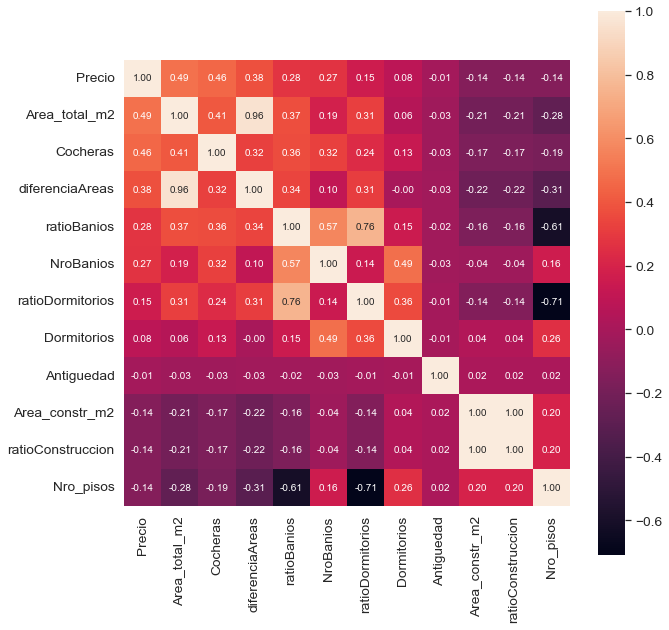

In [26]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
heat_map = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

## DF top 5 corr

In [27]:
df_top5corr = df_num[col_garma]

# Separando dataset en val, test, train

In [28]:
def train_test_val_split(df):
    df_val = df.iloc[int(df.shape[0]*0.9):]
    df_training = df.iloc[:int(df.shape[0]*0.9)]
    df_train, df_test = train_test_split(df_training, random_state = 0, test_size = 0.2)
    return df_train, df_test, df_val

In [29]:
def x_y_split(df, target):
    x =  df.drop(columns = target)
    y = df[target].values
    return x, y

In [30]:
def fit_model(df_train, df_test, df_val, model, normalize = False):
    x_train, y_train = x_y_split(df_train, "Precio")
    x_test, y_test = x_y_split(df_test, "Precio")
    x_val, y_val = x_y_split(df_val, "Precio")
    
    if normalize:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)
        y_val = np.log1p(y_val)
        
    model.fit(x_train, y_train)
    print("train: ",model.score(x_train, y_train))
    print("test: ",model.score(x_test, y_test))
    print("val: ",model.score(x_val, y_val))
    return model

## Modelo 1: variables numericas originales

In [31]:
df_train, df_test, df_val = train_test_val_split(df_num_org)

In [32]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.3370305540127345
test:  0.32580993172511974
val:  0.3067394073643903


## Modelo 2: variables numericas

In [33]:
df_train, df_test, df_val = train_test_val_split(df_num)

In [34]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.41898649286193446
test:  0.2716230297817398
val:  0.39467525274362314


## Modelo 3: primeras 5 corr

In [35]:
df_train, df_test, df_val = train_test_val_split(df_top5corr)

In [36]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.3370000446611974
test:  0.3236877876449834
val:  0.30686457858659355


## Modelo 4: variables numericas normalizando precio

In [37]:
df_train, df_test, df_val = train_test_val_split(df_num)

In [38]:
model = fit_model(df_train, df_test, df_val, LinearRegression(), True)

train:  0.5362166581335345
test:  0.3936900344224654
val:  0.5198767703096199


## Utilizando el feature importance con variables numericas

In [39]:
df_train, df_test, df_val = train_test_val_split(df_num)

In [40]:
x_train, y_train = x_y_split(df_train, "Precio")
x_test, y_test = x_y_split(df_test, "Precio")
x_val, y_val = x_y_split(df_val, "Precio")

In [41]:
column_names = x_train.columns.tolist()

In [42]:
#Escalamiento de las variables
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [43]:
model = LinearRegression()

In [44]:
model.fit(x_train, y_train)

LinearRegression()

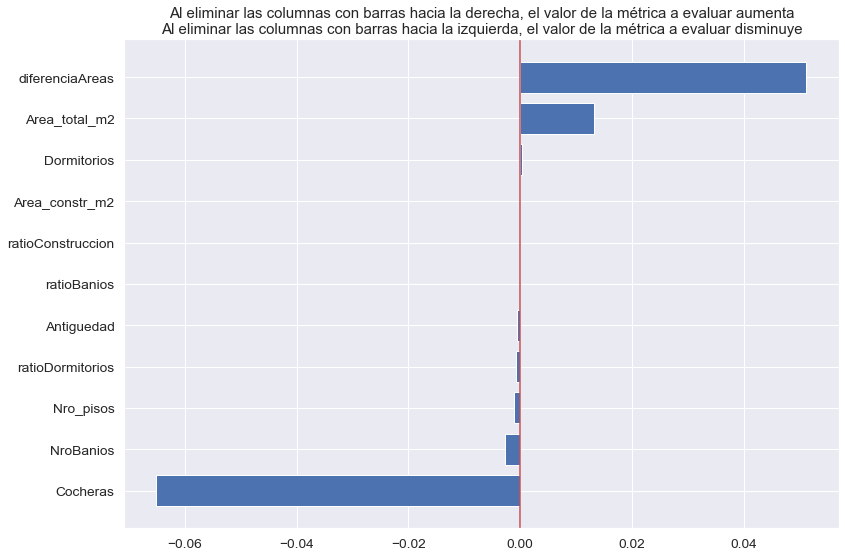

In [45]:
from sklearn.metrics import r2_score
importances_report = get_columns_importance(
                                              model,
                                              x_train=x_train,
                                              y_train=y_train,
                                              x_to_verify=x_test,
                                              y_to_verify=y_test,
                                              metric_to_evaluate=r2_score,
                                              mode="greater",
                                              column_names=column_names
                                            )

## Modelo 5: variables categoricas con imputacion 2

In [46]:
df_train, df_test, df_val = train_test_val_split(df_cat_2)

In [47]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.544561318536082
test:  0.5121169388545718
val:  0.5145909727538679


## Modelo 6: variables categoricas con imputacion 0

In [48]:
df_train, df_test, df_val = train_test_val_split(df_cat_0)

In [49]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.5445610570633772
test:  0.5120226849678065
val:  0.5146731192394917


## Modelo 7: variables categoricas quitando columnas de imputacion

In [50]:
df_train, df_test, df_val = train_test_val_split(df_cat_imp)

In [51]:
model = fit_model(df_train, df_test, df_val, LinearRegression())

train:  0.5436696133217447
test:  0.5118367698804613
val:  0.518225510609224


## Modelo 8: compuesto por los mejores modelos con LinearRegression

In [52]:
df_train, df_test, df_val = train_test_val_split(df_cat_2)

In [53]:
model = fit_model(df_train, df_test, df_val, LinearRegression(), True)

train:  0.769117124961139
test:  0.7296217133461363
val:  0.7438727540507598


## Modelo 9: compuesto por los mejores modelos con LassoLars

In [54]:
df_train, df_test, df_val = train_test_val_split(df_cat_2)

In [55]:
model = fit_model(df_train, df_test, df_val, LassoLars(alpha=.1, normalize=False), True)

train:  0.4639945754667546
test:  0.43574580363856774
val:  0.441376202485146


## Modelo 10: compuesto por los mejores modelos con RandomForestRegressor

In [56]:
from sklearn.ensemble import RandomForestRegressor
df_train, df_test, df_val = train_test_val_split(df_cat_2)
model = RandomForestRegressor(n_estimators=5, random_state=0)

In [57]:
model = fit_model(df_train, df_test, df_val, model, True)

train:  0.951823853016299
test:  0.7768359716563823
val:  0.7792342337333804


## Modelo 11: compuesto por los mejores modelos con Ridge

In [58]:
df_train, df_test, df_val = train_test_val_split(df_cat_2)
model = Ridge(alpha=1.0)

In [59]:
model = fit_model(df_train, df_test, df_val, model, True)

train:  0.7691025976255357
test:  0.7298760324938008
val:  0.7438167056523544


## Modelo 12: compuesto por los mejores modelos con Lasso

In [60]:
df_train, df_test, df_val = train_test_val_split(df_cat_2)
model = Lasso(alpha=0.1)

In [61]:
model = fit_model(df_train, df_test, df_val, model, True)

train:  0.46399435834720304
test:  0.43574279576913677
val:  0.4413713900960332


## Modelo 13: compuesto por los mejores modelos con XGBRegressor

In [64]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

df_train, df_test, df_val = train_test_val_split(df_cat_2)
model = XGBRegressor(tree_method="hist", eval_metric = r2_score)

In [65]:
model = fit_model(df_train, df_test, df_val, model, True)

train:  0.9670327854744787
test:  0.8380338078546273
val:  0.8254673736467446


In [66]:
feature_importances = pd.Series(dict(zip(df_train.drop(columns="Precio").columns, model.feature_importances_)))
feature_importances = feature_importances.sort_values(ascending=False)

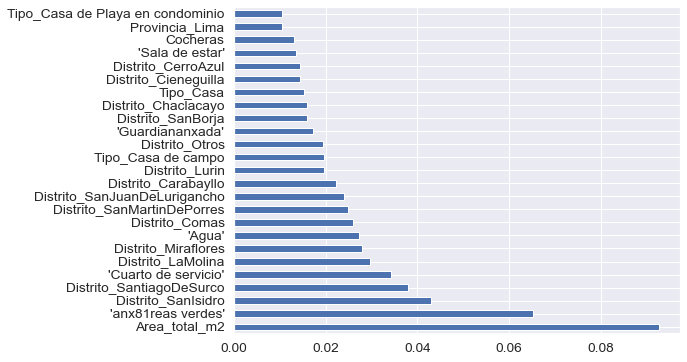

In [67]:
plt.figure(figsize=(8,6))
feature_importances[:25].plot.barh()
plt.show()

# Next Steps

- Evaluar predicciones y su distribucion
- Eliminar variables poco relevantes
- Optimizar hiper parametros
- Aplicar Regularizacion